# Figure 1.b - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

## Computations

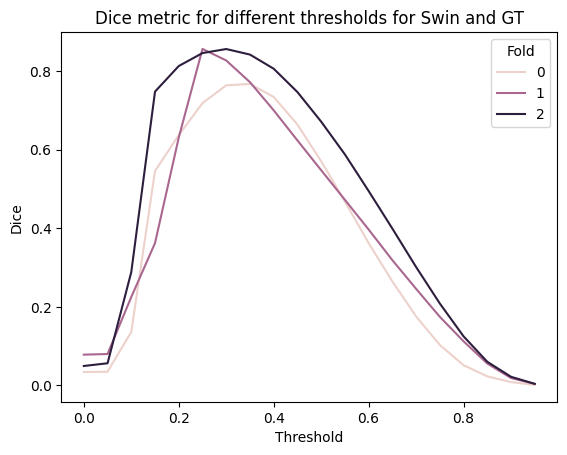

In [5]:
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, segresnet_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin and GT")
plt.show()

In [6]:
dices_df.groupby(["Threshold"]).Dice.mean().sort_values(ascending=False).head(5)

Threshold
0.30    0.815863
0.25    0.807195
0.35    0.793930
0.40    0.747087
0.20    0.693733
Name: Dice, dtype: float64

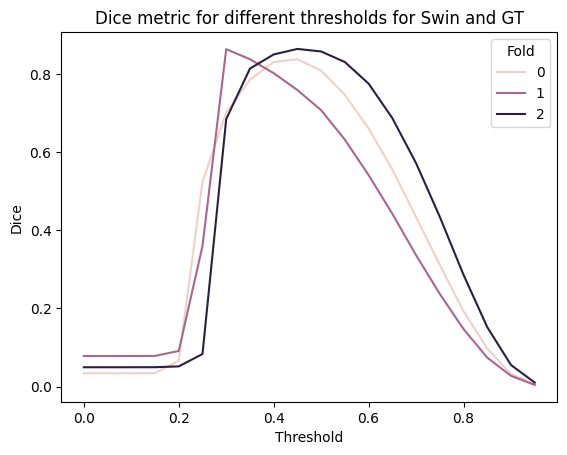

In [7]:
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, swin_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin and GT")
plt.show()

In [8]:
dices_df.groupby("Threshold").Dice.mean().sort_values(ascending=False).head(5)

Threshold
0.40    0.827548
0.45    0.820174
0.35    0.812172
0.50    0.791124
0.30    0.750012
Name: Dice, dtype: float64

In [9]:
swin_thresholded = [np.where(swin > 0.4, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.3, segresnet, 0) for segresnet in segresnet_predictions]

In [10]:
swin_instance = []
segresnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )

In [11]:
# from tifffile import imwrite
# for i in range(len(fold_paths)):
#     save_folder = data_path / f"fold{i+1}" / "processed"
#     save_folder.mkdir(exist_ok=True, parents=False)
#     imwrite(save_folder / "swin_instance.tif", swin_instance[i])
#     imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [12]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   stardist_predictions,
   cellpose_predictions,
   segresnet_instance,
   swin_instance,
   ]
names = [
    "Stardist",
    "Cellpose",
    "SegResNet",
    "SwinUNetR",
    ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        # print(p[j].shape, GT_labels[j].shape)
        pred = p[j]
        if len(pred.shape) > 3:
            pred = pred.squeeze().astype(np.uint32)
        stats = [matching_dataset(
            GT_labels[j], pred, thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on Stardist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Fold  2
Validating on Stardist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************
Fold  3
Validating on Stardist
********************
Validating on Cellpose
********************
Validating on SegResNet
********************
Validating on SwinUNetR
********************


In [13]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision    recall  \
Model     Fold thresh                                                    
Stardist  1    0.1          iou  2045  2908   477   0.587119  0.859084   
               0.2          iou  2595  2358  1027   0.476075  0.696603   
               0.3          iou  3656  1297  2088   0.261861  0.383161   
               0.4          iou  4497   456  2929   0.092065  0.134712   
               0.5          iou  4826   127  3258   0.025641  0.037518   
...                         ...   ...   ...   ...        ...       ...   
SwinUNetR 3    0.5          iou  1325  5728  1181   0.812137  0.829064   
               0.6          iou  2043  5010  1899   0.710336  0.725141   
               0.7          iou  2976  4077  2832   0.578052  0.590100   
               0.8          iou  3925  3128  3781   0.443499  0.452743   
               0.9          iou  5419  1634  5275   0.231674  0.236503   

                       accuracy        f1  n_true  n_pred  mean_true_score  \
Model     Fold thresh                                                        
Stardist  1    0.1     0.535543  0.697529    3385    4953         0.251961   
               0.2     0.394314  0.565603    3385    4953         0.225960   
               0.3     0.184207  0.311106    3385    4953         0.148547   
               0.4     0.057853  0.109379    3385    4953         0.063714   
               0.5     0.015467  0.030463    3385    4953         0.021498   
...                         ...       ...     ...     ...              ...   
SwinUNetR 3    0.5     0.695652  0.820513    6909    7053         0.659073   
               0.6     0.559651  0.717662    6909    7053         0.603425   
               0.7     0.412443  0.584014    6909    7053         0.515481   
               0.8     0.288721  0.448073    6909    7053         0.412785   
               0.9     0.132544  0.234064    6909    7053         0.229932   

                       mean_matched_score  panoptic_quality  by_image  
Model     Fold thresh                                                  
Stardist  1    0.1               0.293290          0.204579     False  
               0.2               0.324375          0.183468     False  
               0.3               0.387689          0.120612     False  
               0.4               0.472966          0.051732     False  
               0.5               0.573006          0.017455     False  
...                                   ...               ...       ...  
SwinUNetR 3    0.5               0.794960          0.652275     False  
               0.6               0.832148          0.597201     False  
               0.7               0.873549          0.510165     False  
               0.8               0.911743          0.408528     False  
               0.9               0.972214          0.227560     False  

[108 rows x 14 columns]

In [14]:
COLORMAP = "tab20"

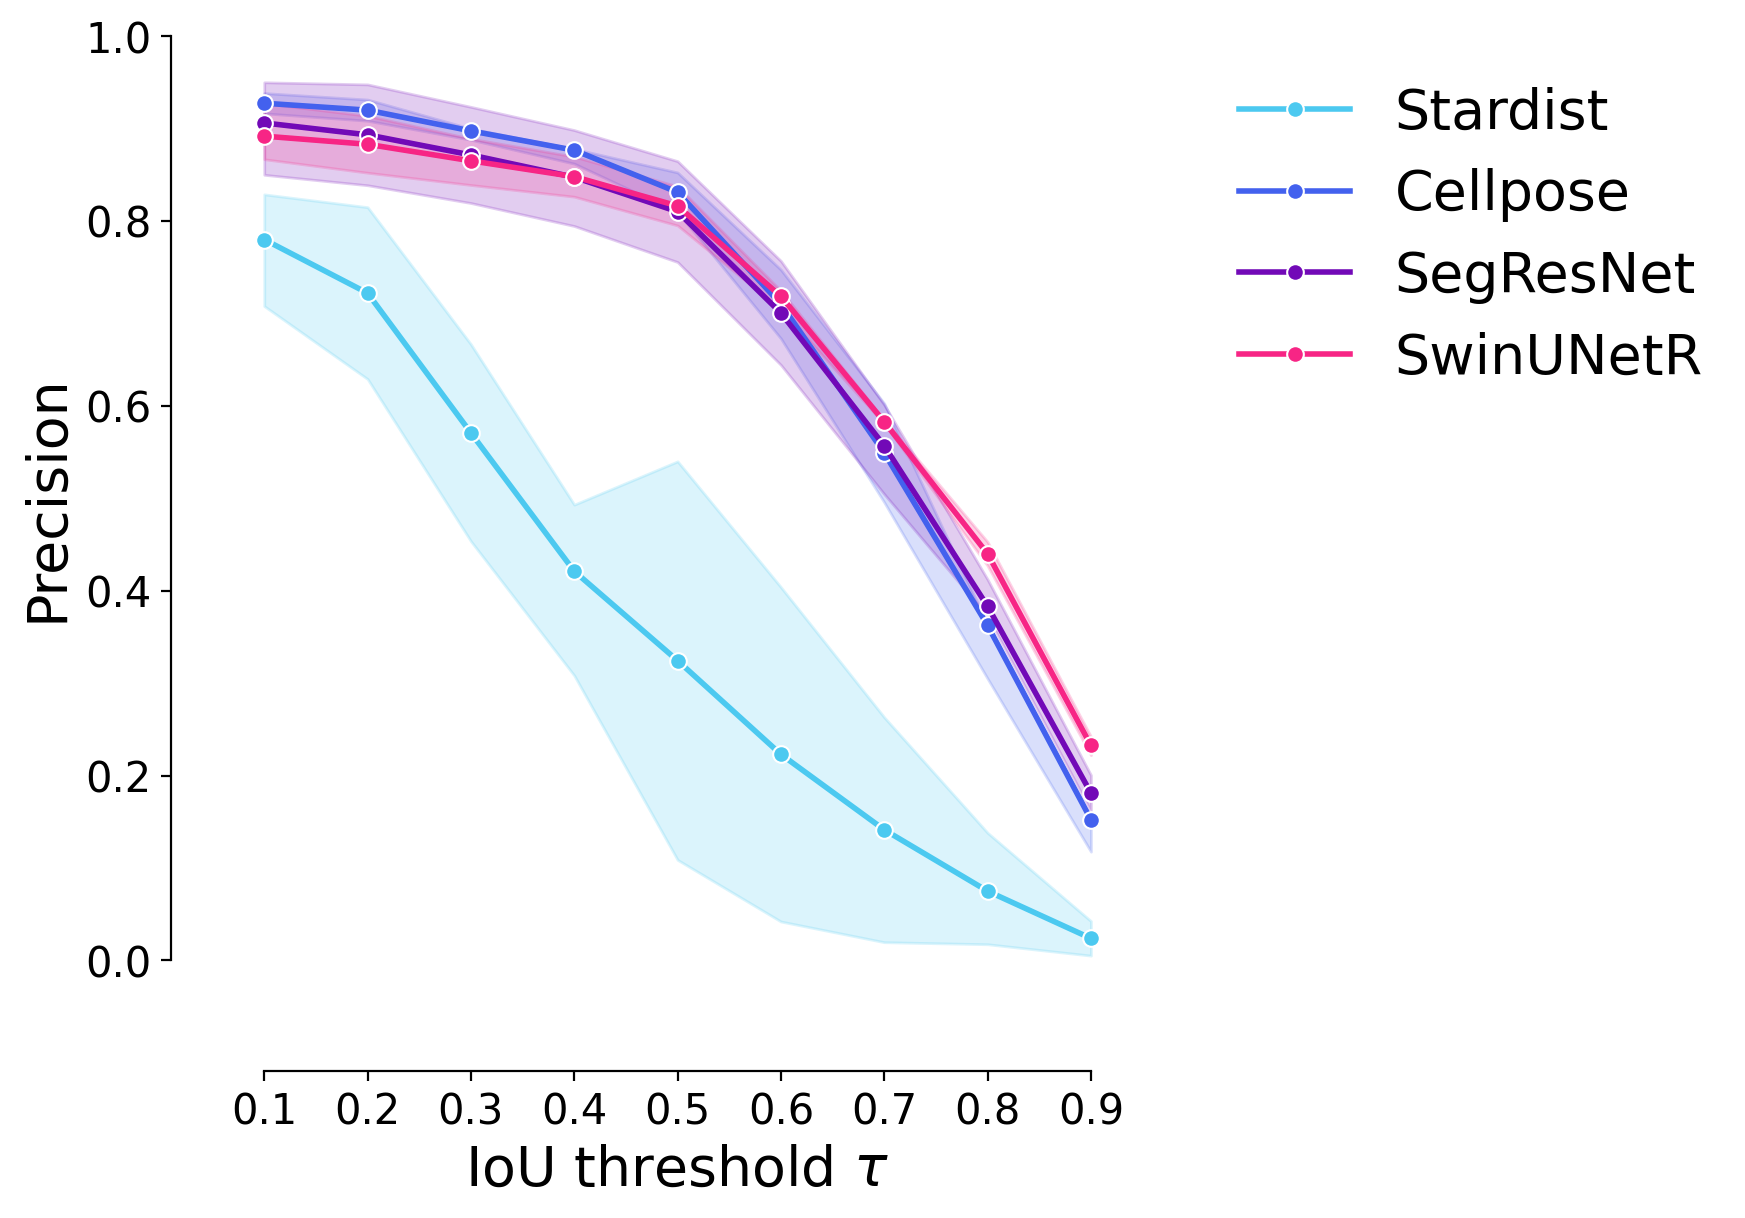

In [15]:
plot_stat_comparison_fold(df, stat="precision")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("precision_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("precision_comparison_fold.svg", bbox_inches = "tight")

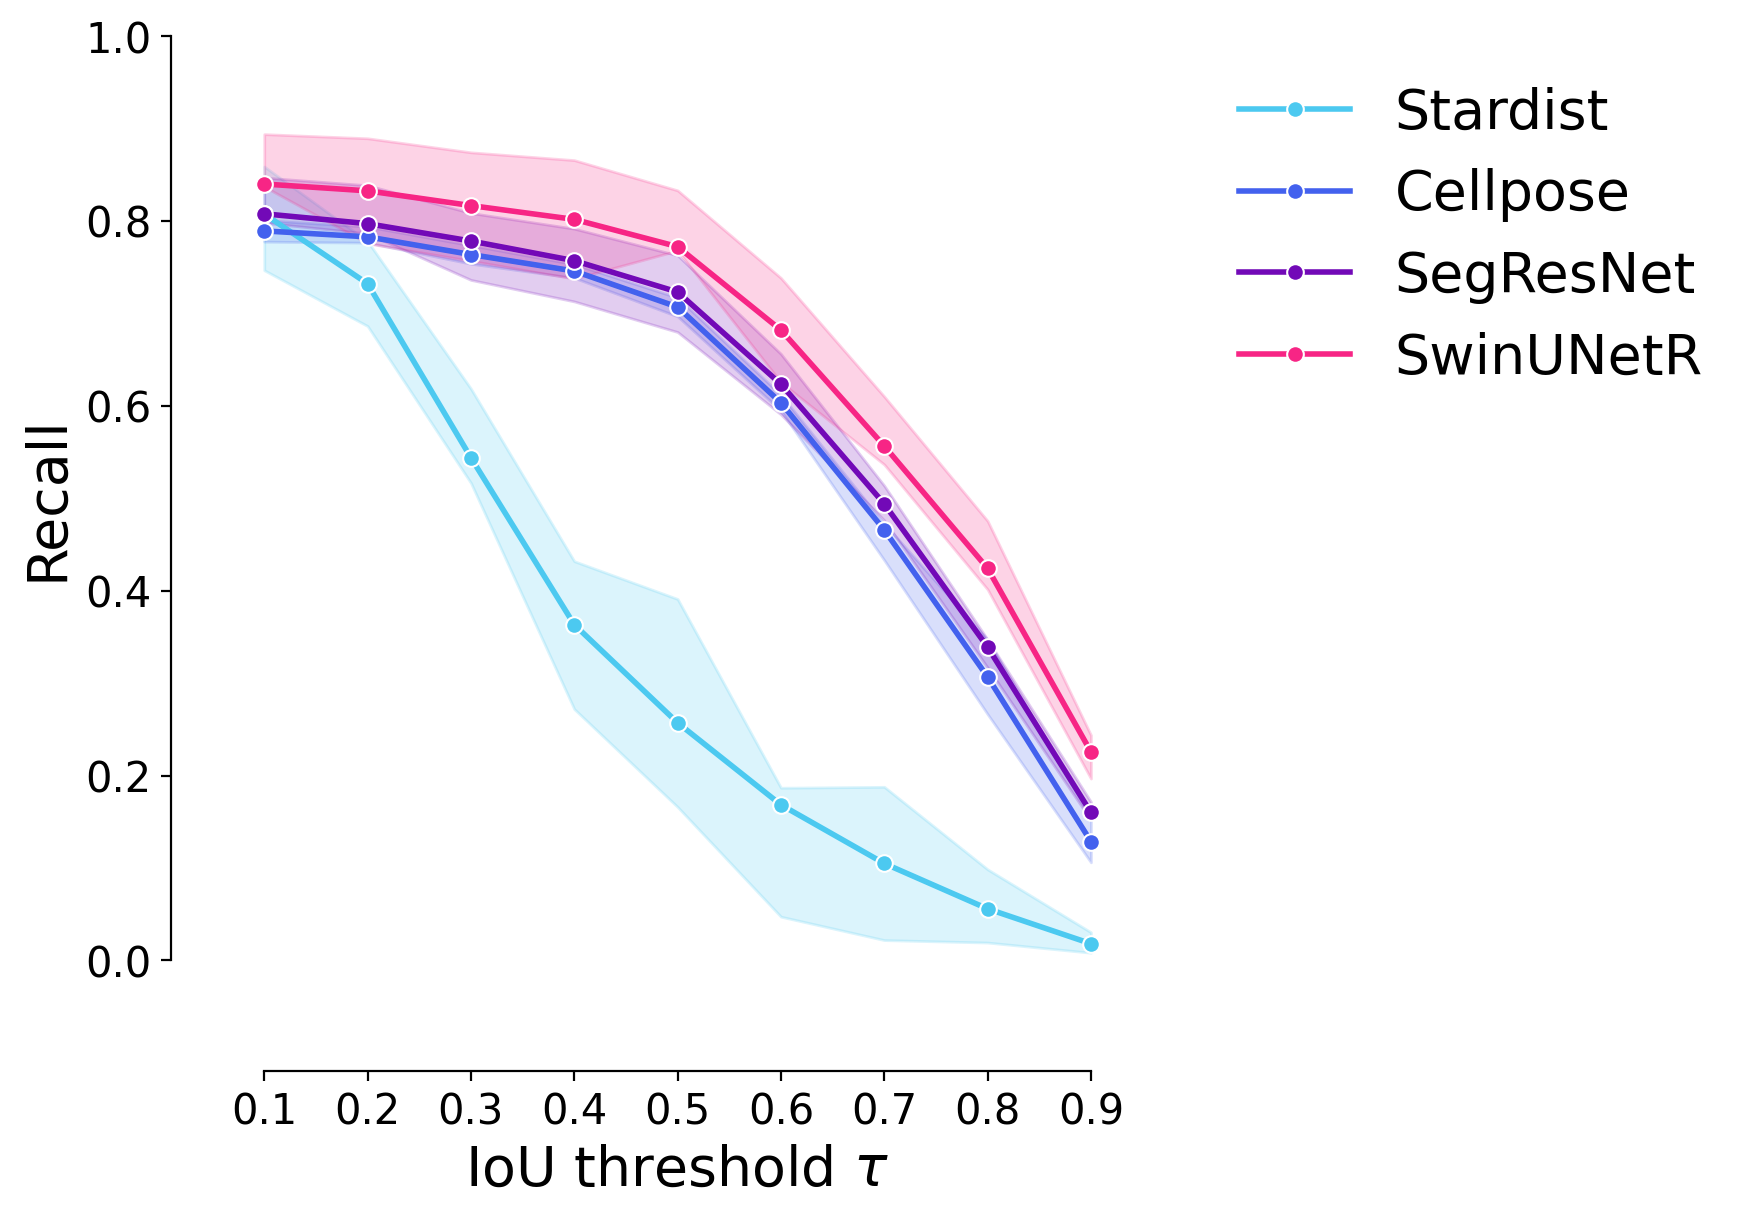

In [16]:
plot_stat_comparison_fold(df, stat="recall")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("recall_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("recall_comparison_fold.svg", bbox_inches = "tight")

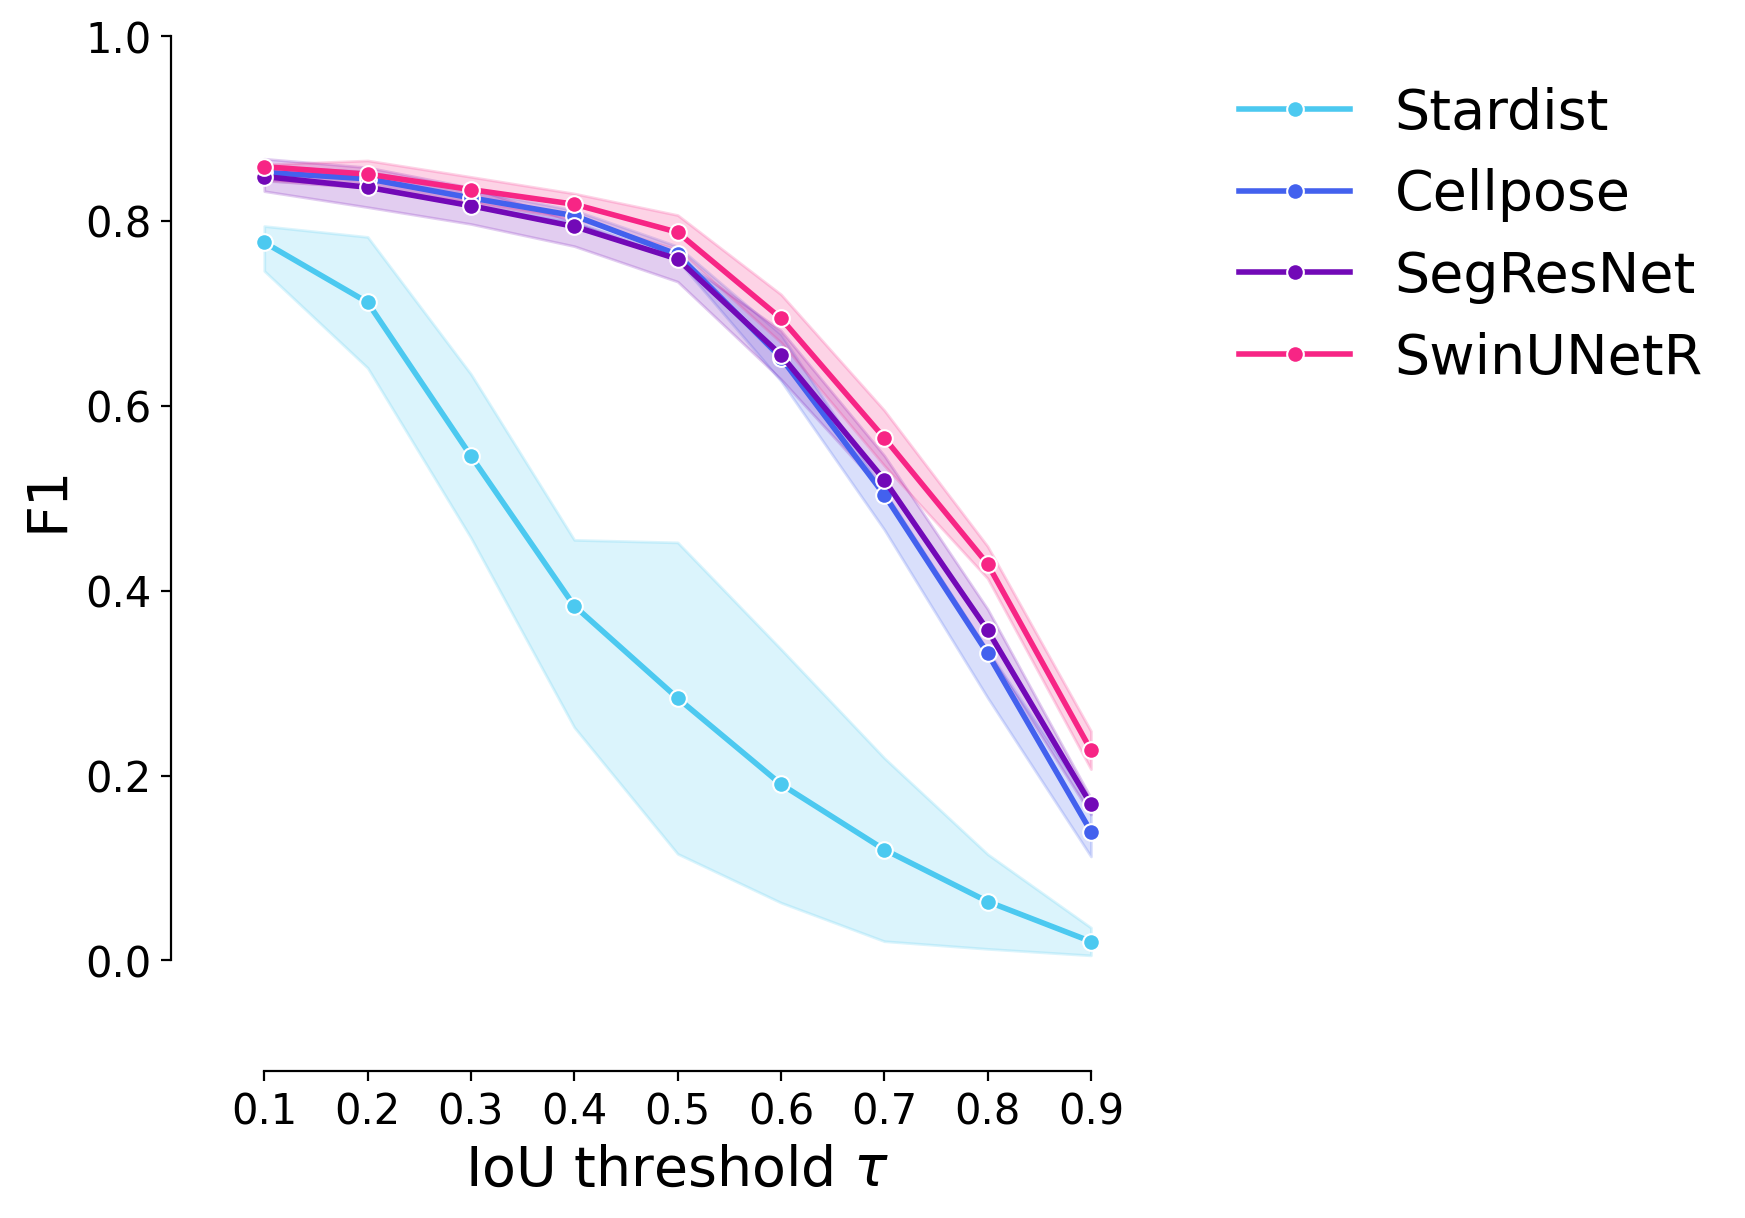

In [17]:
plot_stat_comparison_fold(df, stat="f1")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("f1_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("f1_comparison_fold.svg", bbox_inches = "tight")

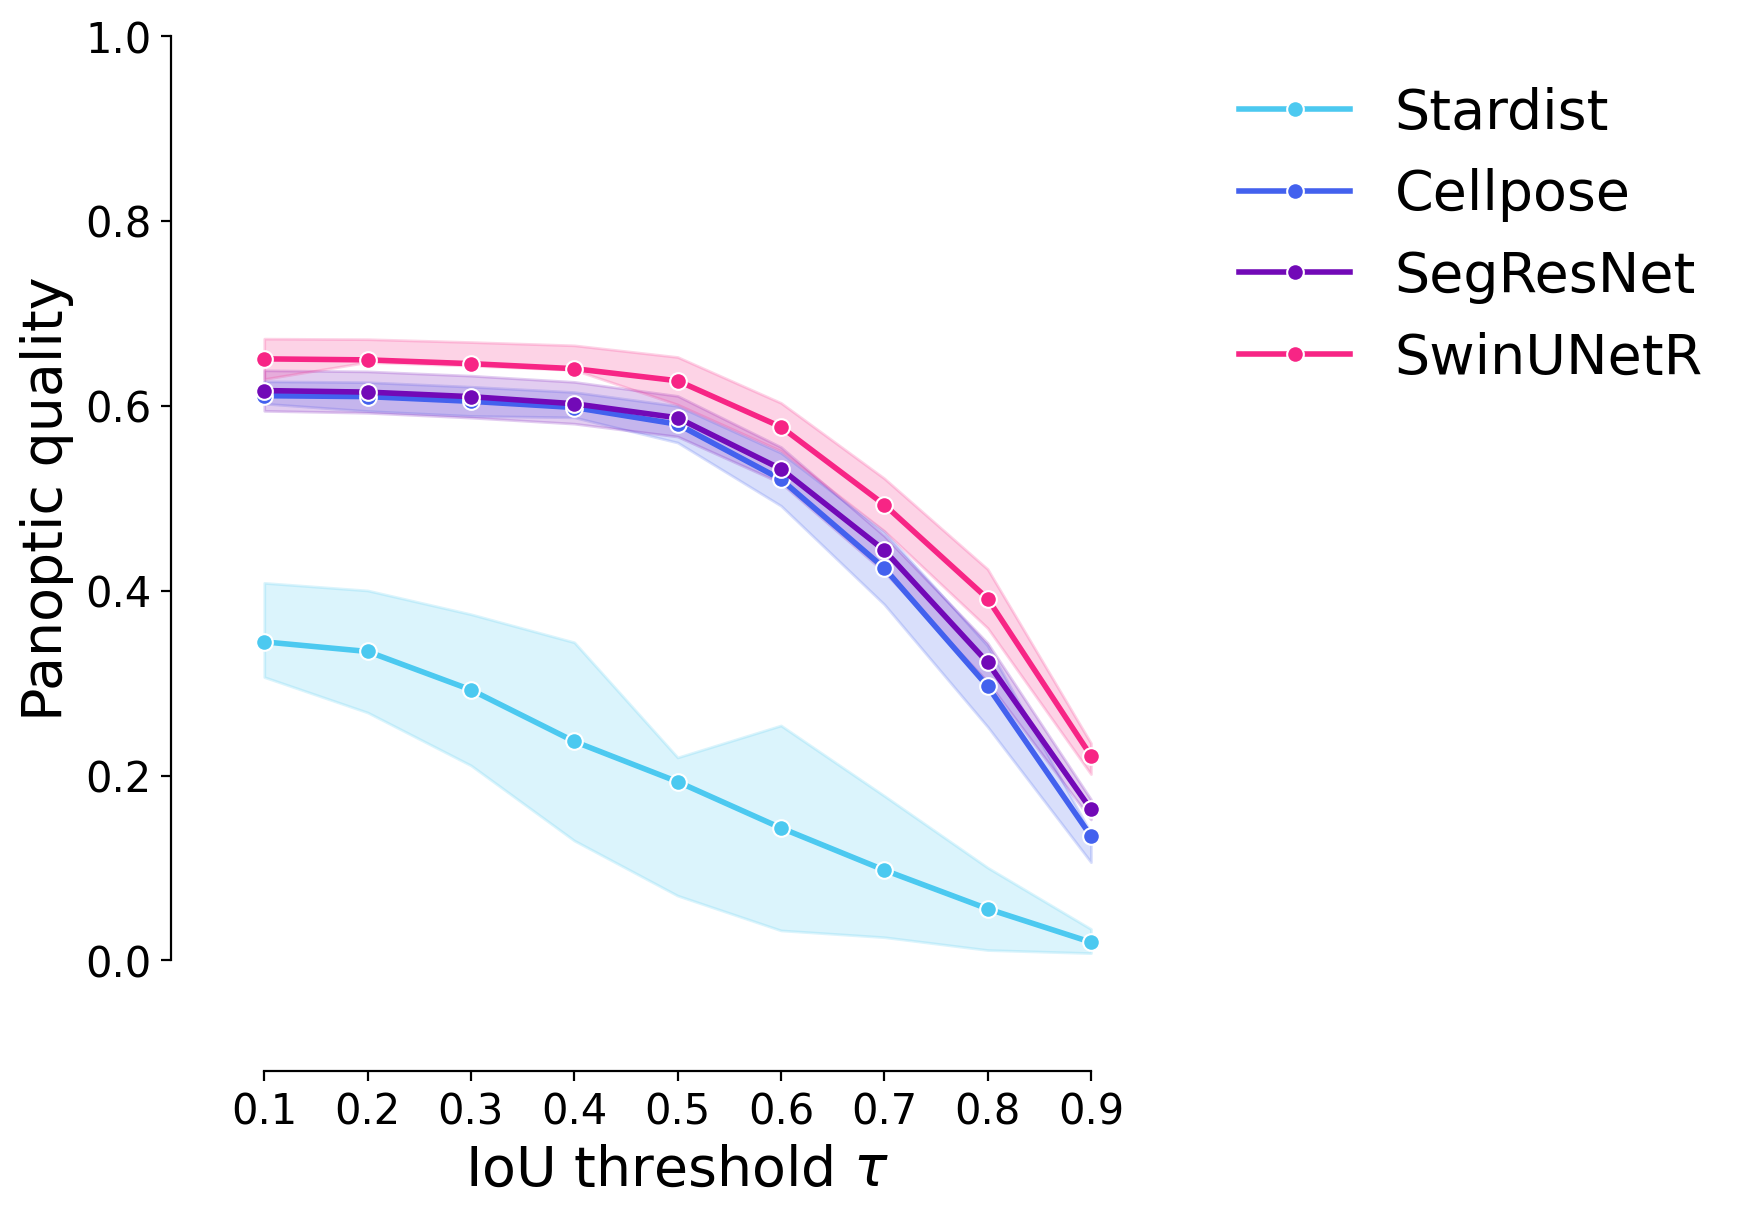

In [18]:
plot_stat_comparison_fold(df, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("panoptic_quality_comparison_fold.svg", bbox_inches = "tight")